In [52]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
import time
import os
from pathlib import Path
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.utils.tensorboard import SummaryWriter

import sys
sys.path.append("..")

import numpy
from tqdm import tqdm

# dataset manager
from dcase2020.datasetManager import DESEDManager
from dcase2020.datasets import DESEDDataset

# utility function & metrics & augmentation
from metric_utils.metrics import FScore, BinaryAccuracy
from dcase2020_task4.util.utils import get_datetime, reset_seed
from dcase2020_task4.util.checkpoint import CheckPoint

# models
from dcase2020_task4.dcase2019.models import dcase2019_model

In [54]:
# ==== set the log ====
import logging
import logging.config
from dcase2020.util.log import DEFAULT_LOGGING
logging.config.dictConfig(DEFAULT_LOGGING)
log = logging.getLogger(__name__)

In [55]:
# ==== reset the seed for reproductability ====
reset_seed(1234)

# Prepare the data

In [56]:
# ==== load the dataset ====
desed_metadata_root = "../dataset/DESED/dataset/metadata"
desed_audio_root = "../dataset/DESED/dataset/audio"
# desed_metadata_root = os.path.join("e:/", "Corpus", "dcase2020", "DESED", "dataset", "metadata")
# desed_audio_root = os.path.join("e:/", "Corpus", "dcase2020", "DESED", "dataset", "audio")

manager = DESEDManager(
    desed_metadata_root, desed_audio_root,
    sampling_rate = 22050,
    from_disk=False,
    nb_vector_bin=431, # there is no temporal reduction in this model
    verbose = 1
)

DEBUG --- datasetManager.__init__ >>> ../dataset/DESED/dataset/audio/dcase2020_dataset_22050.hdf5
INFO --- datasetManager._load_metadata >>> Reading metadata: ../dataset/DESED/dataset/metadata/train/weak.tsv
INFO --- datasetManager._load_metadata >>> Reading metadata: ../dataset/DESED/dataset/metadata/train/unlabel_in_domain.tsv
INFO --- datasetManager._load_metadata >>> Reading metadata: ../dataset/DESED/dataset/metadata/train/synthetic20.tsv


## Add weak ans synthetic20 subset

In [57]:
manager.add_subset("weak")
manager.add_subset("synthetic20")
manager.add_subset("validation")

INFO --- datasetManager._add_train_metadata >>> Loading metadata for: weak
INFO --- datasetManager._add_train_subset >>> Loading dataset: train, subset: weak
DEBUG --- datasetManager._hdf_to_dict >>> hdf_file: <HDF5 file "dcase2020_dataset_22050.hdf5" (mode r)>
DEBUG --- datasetManager._hdf_to_dict >>> path: DESED/dataset/audio/train/weak
INFO --- datasetManager._add_train_metadata >>> Loading metadata for: synthetic20




  0%|          | 0/7582 [00:00<?, ?it/s]

  1%|          | 52/7582 [00:00<00:14, 513.79it/s]

  1%|▏         | 100/7582 [00:00<00:14, 502.13it/s]

  2%|▏         | 152/7582 [00:00<00:14, 506.41it/s]

  3%|▎         | 202/7582 [00:00<00:14, 500.93it/s]

  3%|▎         | 248/7582 [00:00<00:15, 484.85it/s]

  4%|▍         | 301/7582 [00:00<00:14, 496.97it/s]

  5%|▍         | 354/7582 [00:00<00:14, 504.20it/s]

  5%|▌         | 401/7582 [00:00<00:14, 492.36it/s]

  6%|▌         | 448/7582 [00:00<00:15, 474.17it/s]

  7%|▋         | 494/7582 [00:01<00:15, 462.38it/s]

  7%|▋         | 543/7582 [00:01<00:14, 469.32it/s]

  8%|▊         | 594/7582 [00:01<00:14, 479.72it/s]

  8%|▊         | 642/7582 [00:01<00:14, 477.09it/s]

  9%|▉         | 690/7582 [00:01<00:14, 474.80it/s]

 10%|▉         | 738/7582 [00:01<00:14, 467.83it/s]

 10%|█         | 796/7582 [00:01<00:13, 494.05it/s]

 11%|█         | 846/7582 [00:01<00:13, 488.17it/s]

 12%|█▏        | 896/7582 [00:01<00:13, 485.20it/s]

 12

INFO --- datasetManager._add_train_subset >>> Loading dataset: train, subset: synthetic20
DEBUG --- datasetManager._hdf_to_dict >>> hdf_file: <HDF5 file "dcase2020_dataset_22050.hdf5" (mode r)>


DEBUG --- datasetManager._hdf_to_dict >>> path: DESED/dataset/audio/train/synthetic20




  0%|          | 0/4251 [00:00<?, ?it/s]

  1%|▏         | 61/4251 [00:00<00:06, 602.79it/s]

  3%|▎         | 115/4251 [00:00<00:07, 553.14it/s]

  4%|▍         | 163/4251 [00:00<00:07, 528.60it/s]

  5%|▌         | 224/4251 [00:00<00:07, 549.59it/s]

  7%|▋         | 279/4251 [00:00<00:07, 548.91it/s]

  8%|▊         | 325/4251 [00:00<00:08, 487.65it/s]

  9%|▉         | 384/4251 [00:00<00:07, 513.74it/s]

 10%|█         | 440/4251 [00:00<00:07, 524.47it/s]

 12%|█▏        | 497/4251 [00:00<00:06, 536.72it/s]

 13%|█▎        | 550/4251 [00:01<00:07, 523.82it/s]

 14%|█▍        | 602/4251 [00:01<00:07, 517.31it/s]

 15%|█▌        | 654/4251 [00:01<00:08, 431.74it/s]

 16%|█▋        | 700/4251 [00:01<00:08, 430.40it/s]

 18%|█▊        | 759/4251 [00:01<00:07, 468.19it/s]

 19%|█▉        | 813/4251 [00:01<00:07, 485.17it/s]

 20%|██        | 864/4251 [00:01<00:06, 483.94it/s]

 22%|██▏       | 914/4251 [00:01<00:07, 473.26it/s]

 23%|██▎       | 967/4251 [00:01<00:06, 488.39it/s]

 24

INFO --- datasetManager._add_val_subset >>> Loading dataset: validation


DEBUG --- datasetManager._hdf_to_dict >>> hdf_file: <HDF5 file "dcase2020_dataset_22050.hdf5" (mode r)>
DEBUG --- datasetManager._hdf_to_dict >>> path: DESED/dataset/audio/validation


# Prepare training

## Prep dataset

- We want both the weak and strong ground truth --> the *weak* and *strong* parameters to True

In [58]:
augments = [
    # signal_augmentation.Noise(0.5, target_snr=15),
    # signal_augmentation.RandomTimeDropout(0.5, dropout=0.2)
]

train_dataset = DESEDDataset(manager, train=True, val=False, weak=True, strong=True, augments=augments, cached=True)
val_dataset = DESEDDataset(manager, train=False, val=True, weak=True, strong=True, augments=[], cached=True)

In [59]:
len(train_dataset.filenames), len(val_dataset.filenames)

(4049, 1058)

## model

This model is the same than the weak baseline but have an extra output. <br />
the loc_output is compose of a single convolution layer with nb_filters == nb_class. <br />
Since their is some pooling layer, the *loc_ouput* have a precision of 53 bins (~= 18 ms)

In [60]:
torch.cuda.empty_cache() 
model = dcase2019_model()
model.cuda()

dcase2019_model(
  (features): Sequential(
    (0): ConvBNReLUPool(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout2d(p=0.0, inplace=False)
      (3): ReLU6(inplace=True)
      (4): MaxPool2d(kernel_size=(4, 1), stride=(4, 1), padding=0, dilation=1, ceil_mode=False)
    )
    (1): ConvBNReLUPool(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout2d(p=0.0, inplace=False)
      (3): ReLU6(inplace=True)
      (4): MaxPool2d(kernel_size=(4, 1), stride=(4, 1), padding=0, dilation=1, ceil_mode=False)
    )
    (2): ConvBNReLUPool(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout2d(p=0.0,

In [61]:
from torchsummaryX import summary
input_tensor = torch.zeros((2, 64, 431), dtype=torch.float)
input_tensor = input_tensor.cuda()

s = summary(model, input_tensor)


                                 Kernel Shape      Output Shape   Params  \
Layer                                                                      
0_features.0.Conv2d_0           [1, 64, 3, 3]  [2, 64, 64, 431]    640.0   
1_features.0.BatchNorm2d_1               [64]  [2, 64, 64, 431]    128.0   
2_features.0.Dropout2d_2                    -  [2, 64, 64, 431]        -   
3_features.0.ReLU6_3                        -  [2, 64, 64, 431]        -   
4_features.0.MaxPool2d_4                    -  [2, 64, 16, 431]        -   
5_features.1.Conv2d_0          [64, 64, 3, 3]  [2, 64, 16, 431]  36.928k   
6_features.1.BatchNorm2d_1               [64]  [2, 64, 16, 431]    128.0   
7_features.1.Dropout2d_2                    -  [2, 64, 16, 431]        -   
8_features.1.ReLU6_3                        -  [2, 64, 16, 431]        -   
9_features.1.MaxPool2d_4                    -   [2, 64, 4, 431]        -   
10_features.2.Conv2d_0         [64, 64, 3, 3]   [2, 64, 4, 431]  36.928k   
11_features.

## Create a custom loss function

Since not all file have strong truth, it is necessary to remove those files. <br />
For that, the strong mask is computed. If the sum of the strong ground truth is equal to 0 then it is a fake one <br />
This file strong loss must not be taken into account.

In [62]:
def weak_synth_loss(logits_weak, logits_strong, y_weak, y_strong, reduce: str = "mean"):
    assert reduce in ["mean", "sum"], "support only \"mean\" and \"sum\""
    
    #  Reduction function
    if reduce == "mean":
        reduce_fn = torch.mean
    elif reduce == "sum":
        reduce_fn = torch.sum
    
    # based on Binary Cross Entropy loss
    weak_criterion = nn.BCEWithLogitsLoss(reduction="none")
    strong_criterion = nn.BCEWithLogitsLoss(reduction="none")
    
    # calc separate loss function
    weak_bce = weak_criterion(logits_weak, y_weak)
    strong_bce = strong_criterion(logits_strong, y_strong)
    
    weak_bce = reduce_fn(weak_bce, dim=1)
    strong_bce = reduce_fn(strong_bce, dim=(1, 2))
    
    # calc strong mask
    strong_mask = torch.clamp(torch.sum(y_strong, dim=(1, 2)), 0, 1) # vector of 0 or 1
#     strong_mask = strong_mask.detach() # declared not to need gradients
    
    # Output the different loss for logging purpose
    weak_loss = reduce_fn(weak_bce)
    strong_loss = reduce_fn(strong_mask * strong_bce)
    total_loss = reduce_fn(weak_bce + strong_mask * strong_bce)
    
    return weak_loss, strong_loss, total_loss

## Training parameters (crit & callbacks & loaders & metrics)m

In [63]:
# training parameters
nb_epochs = 100
batch_size = 32
nb_batch = len(train_dataset) // batch_size

optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

# callbacks
checkpoint = CheckPoint(model, optimizer, mode="max", name="../models/best_dcase2019.torch")
callbacks = []

# tensorboard
title = "WeakBaseline_%s" % (get_datetime())
tensorboard = SummaryWriter(log_dir=Path("../tensorboard/%s" % title), comment="weak baseline")

# loaders
training_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Metrics
weak_binacc_func = BinaryAccuracy()
strong_binacc_func = BinaryAccuracy()
weak_f_func = FScore()
strong_f_func = FScore()
metrics = [weak_binacc_func, strong_binacc_func, weak_f_func, strong_f_func]

In [64]:
def reset_all_metrics(metrics):
    for m in metrics:
        m.reset()

## Training functions

In [65]:
UNDERLINE_SEQ = "\033[1;4m"
RESET_SEQ = "\033[0m"

header_form = "{:<8.8} {:<6.6} - {:<6.6} - {:<8.8} {:<6.6}| {:<8.8}| {:<6.6} - {:<9.9} {:<10.10}| {:<12.12}| {:<9.9}| {:<11.11}- {:<6.6}"

value_form  = "{:<8.8} {:<6} - {:<6} - {:<8.8} {:<6.4f}| {:<8.4f}| {:<6.4f} - {:<9.9} {:<10.4f}| {:<12.4f}| {:<9.4f}| {:<11.4f}- {:<6.4f}"

train_form = value_form
val_form = UNDERLINE_SEQ + value_form + RESET_SEQ

header = header_form.format(
    "", "Epoch", "%", "Losses:", "Weak ", "Strong ", "Total ", "metrics: ", "Weak acc ", "Strong acc ", "Weak F1 ", "Strong F1", "Time"
)

print(header)

         Epoch  - %      - Losses:  Weak  | Strong  | Total  - metrics:  Weak acc  | Strong acc  | Weak F1  | Strong F1  - Time  


In [66]:
def train(epoch: int):
    start_time = time.time()
    
    reset_all_metrics(metrics)
    
    model.train()
    print("") # <-- Force new line
    
    for i, (X, y) in enumerate(training_loader):
        # The DESEDDataset return a list of ground truth depending on the selecting option.
        # If weak and strong ground truth are selected, the list order is [WEAK, STRONG]
        # here there is only one [WEAK]
        X = X.cuda().float()
        y_weak = y[0].cuda().float()
        y_strong = y[1].cuda().float()
        
        weak_logits, strong_logits = model(X)
        
        # calc the loss
        weak_loss, strong_loss, total_loss = weak_synth_loss(
            weak_logits, strong_logits,
            y_weak, y_strong,
            reduce="mean"
        )
        
        # back propagation
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        with torch.set_grad_enabled(False):
            # calc metrics
            weak_pred = torch.sigmoid(weak_logits)
            strong_pred = torch.sigmoid(strong_logits)

            # tagging
            weak_binacc = weak_binacc_func(weak_pred, y_weak)
            weak_fscore = weak_f_func(weak_pred, y_weak)

            # loc
            strong_binacc = strong_binacc_func(strong_pred, y_strong)
            strong_fscore = strong_f_func(strong_pred, y_strong)
        
            # logs
            print(train_form.format(
                "Training: ",
                epoch + 1,
                int(100 * (i + 1) / len(training_loader)),
                "", weak_loss.item(), strong_loss.item(), total_loss.item(),
                "", weak_binacc, strong_binacc, weak_fscore, strong_fscore,
                time.time() - start_time
            ), end="\r")

        # tensorboard logs
        tensorboard.add_scalar("train/weak_loss", weak_loss.item(), epoch)
        tensorboard.add_scalar("train/strong_loss", strong_loss.item(), epoch)
        tensorboard.add_scalar("train/total_loss", total_loss.item(), epoch)

        tensorboard.add_scalar("train/weak_acc", weak_binacc, epoch)
        tensorboard.add_scalar("train/strong_acc", strong_binacc, epoch)
        tensorboard.add_scalar("train/weak_f1", weak_fscore, epoch)
        tensorboard.add_scalar("train/strong_f1", strong_fscore, epoch)

In [67]:
def val(epoch):
    start_time = time.time()

        
    reset_all_metrics(metrics)
    
    model.eval()
    print("") # <-- Force new line
    
    with torch.set_grad_enabled(False):
        for i, (X, y) in enumerate(val_loader):
            X = X.cuda().float()
            y_weak = y[0].cuda().float()
            y_strong = y[1].cuda().float()

            weak_logits, strong_logits = model(X)

            # calc the loss
            weak_loss, strong_loss, total_loss = weak_synth_loss(
                weak_logits, strong_logits,
                y_weak, y_strong,
                reduce="mean"
            )
            
             # calc metrics
            weak_pred = torch.sigmoid(weak_logits)
            strong_pred = torch.sigmoid(strong_logits)

            # tagging
            weak_binacc = weak_binacc_func(weak_pred, y_weak)
            weak_fscore = weak_f_func(weak_pred, y_weak)

            # loc
            strong_binacc = strong_binacc_func(strong_pred, y_strong)
            strong_fscore = strong_f_func(strong_pred, y_strong)
            
            # The interesting metric here is the weak F1
            checkpoint.step(weak_fscore)

            # logs
            print(val_form.format(
                "Validation: ",
                epoch + 1,
                int(100 * (i + 1) / len(val_loader)),
                "", weak_loss.item(), strong_loss.item(), total_loss.item(),
                "", weak_binacc, strong_binacc, weak_fscore, strong_fscore,
                time.time() - start_time
            ), end="\r")

        # tensorboard logs
        tensorboard.add_scalar("val/weak_loss", weak_loss.item(), epoch)
        tensorboard.add_scalar("val/strong_loss", strong_loss.item(), epoch)
        tensorboard.add_scalar("val/total_loss", total_loss.item(), epoch)

        tensorboard.add_scalar("val/weak_acc", weak_binacc, epoch)
        tensorboard.add_scalar("val/strong_acc", strong_binacc, epoch)
        tensorboard.add_scalar("val/weak_f1", weak_fscore, epoch)
        tensorboard.add_scalar("val/strong_f1", strong_fscore, epoch)

# Train

In [68]:
# tensorboard
title = "dcase2019_system_%s" % (get_datetime())
tensorboard = SummaryWriter(log_dir=Path("../tensorboard/%s" % title), comment="weak baseline")

print(header)
for e in range(nb_epochs):
    train(e)
    val(e)

         Epoch  - %      - Losses:  Weak  | Strong  | Total  - metrics:  Weak acc  | Strong acc  | Weak F1  | Strong F1  - Time  

Training 1      - 100    -          0.3251| 0.0915  | 0.4166 -           0.8347    | 0.9555      | 0.2694   | 0.0170     - 63.7409

INFO --- checkpoint.step >>> Best performance reached: saving the model
Validati 1      - 5      -          0.3774| 0.2619  | 0.6392 -           0.8500    | 0.9139      | 0.1587   | 0.0988     - 0.0863
INFO --- checkpoint.step >>> Best performance reached: saving the model
Validati 1      - 8      -          0.3344| 0.2308  | 0.5652 -           0.8563    | 0.9178      | 0.2391   | 0.1110     - 0.1290
INFO --- checkpoint.step >>> Best performance reached: saving the model
Validati 1      - 11     -          0.3948| 0.2641  | 0.6589 -           0.8531    | 0.9127      | 0.2400   | 0.0958     - 0.1704
INFO --- checkpoint.step >>> Best performance reached: saving the model
Validati 1      - 14     -          0.3557| 0.2726  | 0.628

# Optimization before evaluation - ♫♪.ılılıll|̲̅̅●̲̅̅|̲̅̅=̲̅̅|̲̅̅●̲̅̅|llılılı.♫♪
At this stage, we will work with the output of the best epoch on the validation dataset. The process is done into 3 stages
- The optimization of tagging performance using simulating annealing
- The pruning of the strong prediction
- The optimization of the localization system using aeseg (hysteresis thresholding)

## Load best state 

In [69]:
best_model = dcase2019_model()
best_model.cuda()
best_model.eval() # <-- for consistency in scoring (deactivate dropout and batchNorm)

checkpoint = torch.load("../models/best_dcase2019.torch")
best_model.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

## Perform prediction on validation dataset

In [70]:
weak_y_true, strong_y_true = None, None
weak_y_pred, strong_y_pred = None, None
y_filenames = list(val_dataset.X.keys())

with torch.set_grad_enabled(False):
    for i, (X, y) in enumerate(val_loader):
        weak_y, strong_y = y
        weak_y, strong_y = weak_y.cuda(), strong_y.cuda()
        X = X.cuda()
        
        weak_logits, strong_logits = model(X)
        
        weak_pred = torch.sigmoid(weak_logits)
        strong_pred = torch.sigmoid(strong_logits)
        
        # accumulate prediction and ground truth
        if i == 0:
            weak_y_true = weak_y.cpu()
            strong_y_true = strong_y.cpu()

            weak_y_pred =  weak_pred.cpu()
            strong_y_pred =  strong_pred.cpu()
        else:
            weak_y_true = torch.cat((weak_y_true, weak_y.cpu()), dim=0)
            strong_y_true = torch.cat((strong_y_true, strong_y.cpu()), dim=0)

            weak_y_pred =  torch.cat((weak_y_pred, weak_pred.cpu()), dim=0)
            strong_y_pred =  torch.cat((strong_y_pred, strong_pred.cpu()), dim=0)
        
        print(" %d %%" % int(100 * (i + 1) / len(val_loader)), end="\r")

In [71]:
weak_y_true.shape, weak_y_pred.shape, strong_y_true.shape, strong_y_pred.shape, len(y_filenames)

(torch.Size([1058, 10]),
 torch.Size([1058, 10]),
 torch.Size([1058, 10, 431]),
 torch.Size([1058, 10, 431]),
 1058)

## Audio tagging threshold Optimization

In [72]:
classwise_f1 = FScore(dim=0)
def simulated_anealing(y_pred, y_true, macro_iteration = 50, micro_iteration = 400):
    weak_y_pred_ = y_pred.clone().detach()

    start_f1 = classwise_f1(weak_y_pred_, weak_y_true)

    min_delta = 10e-7
    delta_ratio = 0.2
#     macro_iteration = 30
#     micro_iteration = 400

    history = {
        "best_f1": [[] for _ in range(10)],
        "f1": [],
        "delta_ratio": []
    }

    best_thresholds = torch.ones(10) * 0.5
    best_f1 = start_f1.clone().detach()

    total_iteration = macro_iteration * micro_iteration
    
    for M in range(macro_iteration):
        thresholds = torch.ones(10) * 0.5
        delta_ratio = 0.2
        delta_decay = ( (min_delta + delta_ratio) / micro_iteration )

        for m in range(micro_iteration):
            bin_y_pred = y_pred.clone().detach()

            # calc new threhsold
            r = torch.normal(mean=thresholds, std=0.4)
            delta = r * delta_ratio
            new_thresholds = thresholds + delta
            delta_ratio -= delta_decay
            history["delta_ratio"].append(delta_ratio)

            # apply threshold
            weak_y_pred_[bin_y_pred > new_thresholds] = 1
            weak_y_pred_[bin_y_pred <= new_thresholds] = 0

            # calc new f1
            new_f1 = classwise_f1(weak_y_pred_, weak_y_true)
            history["f1"].append(new_f1)

            # check
            for i in range(10):
                if new_f1[i] > best_f1[i]:
#                     print(new_f1[i], " > ", best_f1[i])
                    best_f1[i] = new_f1[i]
                    best_thresholds[i] = new_thresholds[i]
                    thresholds[i] = best_thresholds[i]
                    history["best_f1"][i].append(best_f1[i])

            step = M * micro_iteration + m
            print("%2.2f / 100.0 (%%)" % ((step / total_iteration) * 100), end="\r")
            
    return start_f1, best_f1, best_thresholds, history

In [73]:
initial_f1, best_f1, best_at_thresholds, history = simulated_anealing(weak_y_pred, weak_y_true, 20, 400)

In [74]:
torch.mean(initial_f1), torch.mean(best_f1)

(tensor(0.6400), tensor(0.6429))

In [75]:
best_at_thresholds

tensor([0.5000, 0.5000, 0.7808, 0.5524, 0.8155, 0.5000, 0.5000, 0.6511, 0.6245,
        0.6663])

## Apply new threshold and perform pruning on strong prediction

In [76]:
best_weak_y_pred = weak_y_pred.clone().detach()

best_weak_y_pred[best_weak_y_pred > best_at_thresholds] = 1
best_weak_y_pred[best_weak_y_pred <= best_at_thresholds] = 0

In [77]:
best_weak_y_pred.shape, strong_y_pred.shape

(torch.Size([1058, 10]), torch.Size([1058, 10, 431]))

In [78]:
# Prune the result of fill the missing curve with 0 segments
def prune_prediction(strong_y_pred, weak_y_pred):
    """ Prune the strong prediciton by zeroing all classes that are not predicted. """
    pruned_strong_y_pred = strong_y_pred.clone().detach()
    
    for index in range(len(pruned_strong_y_pred)):
        cls_result = weak_y_pred[index]
        
        # Create a full mask using repeat
        length = strong_y_pred.size()[-1]
        cls_mask = cls_result.unsqueeze(1).repeat(1, length)
        pruned_strong_y_pred[index] *= cls_mask
                
    return pruned_strong_y_pred

In [79]:
pruned_strong_y_pred = prune_prediction(strong_y_pred, best_weak_y_pred)

### Sanity check and visualization

In [80]:
best_weak_y_pred[1], pruned_strong_y_pred[1]

(tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.2572, 0.3861, 0.4987,  ..., 0.0025, 0.0031, 0.0331]]))

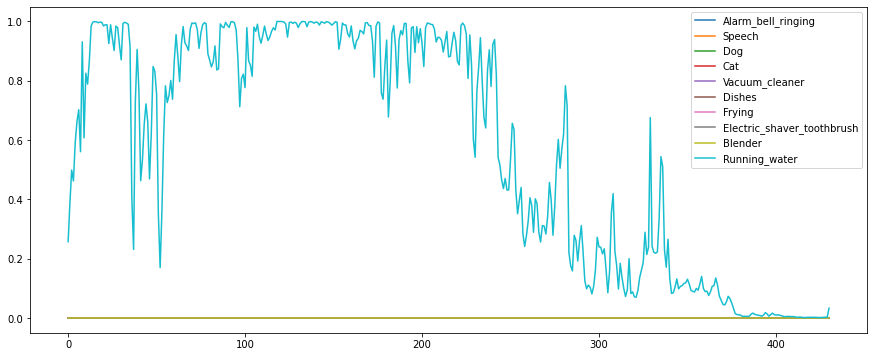

In [81]:
import matplotlib.pyplot as plt

class_list = list(DESEDManager.cls_dict.keys())
plt.figure(0, figsize=(15, 6))

for i, class_name in enumerate(class_list):
    plt.plot(pruned_strong_y_pred[1][i], label=class_name)

plt.legend()
plt.show()

# Perform segmentation of the prediction curves

In [82]:
# pip install -i https://test.pypi.org/simple/ aeseg

In [83]:
from aeseg.Encoder import Encoder
from aeseg.optimizers import GenOptimizer, DichotomicOptimizer
from aeseg.core import eb_evaluator, sb_evaluator

In [84]:
def load_csv(path):
    with open(path, "r") as f:
        data = f.read().splitlines()[1:]
    return data

In [85]:
## Optimizer take data in the following shape (file, seq, class)
strong_y_true = strong_y_true.permute(0, 2, 1)
pruned_strong_y_pred = pruned_strong_y_pred.permute(0, 2, 1)
strong_y_true.shape, pruned_strong_y_pred.shape

(torch.Size([1058, 431, 10]), torch.Size([1058, 431, 10]))

In [86]:
def class_wise_optimization(optimizer, class_to_monitor, strong_y_true, strong_pred, filenames, method="threshold"):
    class_wise_results = {}
    
    for cl in class_to_monitor:
        optimizer.fit(
            strong_y_true, strong_pred, filenames,
            monitor=["class_wise", cl, "f_measure", "f_measure"],
            method=method,
            verbose=1)
        
        parameters, score = optimizer.best
        print(cl, parameters, score)
        class_wise_results[cl] = (parameters, score)
        
    return class_wise_results


def get_class_dependant_parameters(class_wise_results, class_list):
    class_dependant_parameters = {}
    for cl in class_list:
        for param in class_wise_results[cl][0]:
            if param not in class_dependant_parameters.keys():
                class_dependant_parameters[param] = []
            class_dependant_parameters[param].append(class_wise_results[cl][0][param])
            
    # TODO find better way
    # for "smooth" common parameters, remove list
    class_dependant_parameters["smooth"] = class_dependant_parameters["smooth"][0]
    return class_dependant_parameters

In [87]:
class_list = list(DESEDManager.cls_dict.keys())

# Create the encoder that will be used
encoder = Encoder(
    classes=class_list,
    temporal_precision = 50,  # ms
    clip_length = 10,          # s
    minimal_segment_step = 150 # ms
)

val_csv_y_true= load_csv(os.path.join(desed_metadata_root, "validation", "validation.tsv"))

## Absolute threshold

In [ ]:
optimizer = DichotomicOptimizer(
    {
        "threshold": (0.01, 0.90),
        "smooth": "smoothMovingAvg",
        "window_len": (5, 27)
    },
    
    encoder = encoder,
    step = 6,
    nb_recurse = 8,
    nb_process = 5
)

class_wise_results = class_wise_optimization(
    optimizer,
    class_list,
    method="threshold",
    strong_y_true=val_csv_y_true,
    strong_pred=pruned_strong_y_pred.numpy(),
    filenames=y_filenames
)

In [89]:
best_parameters = get_class_dependant_parameters(class_wise_results, class_list)

In [95]:
for key, value in best_parameters.items():
    print("{:<15}: {}".format(key, value))

threshold      : [0.8077932007619048, 0.787688, 0.36812160000000005, 0.9, 0.35367360000000003, 0.23318249472000002, 0.01571766857142857, 0.011932665904761905, 0.22503004160000004, 0.5921951809015873]
smooth         : smoothMovingAvg
window_len     : [8.697109942857143, 11.803439999999998, 13.946666666666667, 9.853818294857142, 27.0, 8.683605333333334, 26.035776, 27.0, 20.918436266666667, 27.0]


In [93]:
# check test
best_parameters = get_class_dependant_parameters(class_wise_results, class_list)

segments = encoder.encode(
    pruned_strong_y_pred.numpy(),
    method="threshold",
    **best_parameters
)
to_evaluate = encoder.parse(segments, y_filenames)
evaluator = eb_evaluator(val_csv_y_true, to_evaluate)
print(evaluator)

Event based metrics (onset-offset)
  Evaluated length                  : 10459.12 sec
  Evaluated files                   : 1168 
  Evaluate onset                    : True 
  Evaluate offset                   : True 
  T collar                          : 200.00 ms
  Offset (length)                   : 20.00 %

  Overall metrics (micro-average)
  F-measure
    F-measure (F1)                  : 26.02 %
    Precision                       : 30.80 %
    Recall                          : 22.52 %
  Error rate
    Error rate (ER)                 : 1.26 
    Substitution rate               : 0.02 
    Deletion rate                   : 0.76 
    Insertion rate                  : 0.49 

  Class-wise average metrics (macro-average)
  F-measure
    F-measure (F1)                  : 25.43 %
    Precision                       : 28.03 %
    Recall                          : 23.87 %
  Error rate
    Error rate (ER)                 : 1.43 
    Deletion rate                   : 0.76 
    Insertion rat

## Hysteresis thresholding

In [241]:
# Perform the optimization ON TEST
# Create the optimizer
optimizer = DichotomicOptimizer(
    {
        "high": (0.01, 0.99),
        "low": (0.01, 0.99),
#         "smooth": "smoothMovingAvg",
        "window_len": (3, 27)
    },
    
    encoder = encoder,
    step = 6,
    nb_recurse = 8,
    nb_process = 5
)

class_wise_results = class_wise_optimization(
    optimizer,
    class_list,
    method="hysteresis",
    strong_y_true=strong_y_true,
    strong_pred=pruned_strong_y_pred.numpy(),
    filenames=y_filenames
)














  0%|          | 0/1728 [00:00<?, ?it/s]

IndexError: list index out of range

In [87]:
best_parameters = get_class_dependant_parameters(class_wise_results, class_list)

In [88]:
# check test
best_parameters = get_class_dependant_parameters(class_wise_results, class_list)

segments = encoder.encode(
    val_strong_pred,
    method="hysteresis",
    **best_parameters
)
to_evaluate = encoder.parse(segments, val_filenames)
evaluator = eb_evaluator(val_csv_y_true, to_evaluate)
print(evaluator)

Event based metrics (onset-offset)
  Evaluated length                  : 10161.15 sec
  Evaluated files                   : 1168 
  Evaluate onset                    : True 
  Evaluate offset                   : True 
  T collar                          : 200.00 ms
  Offset (length)                   : 20.00 %

  Overall metrics (micro-average)
  F-measure
    F-measure (F1)                  : 36.63 %
    Precision                       : 40.38 %
    Recall                          : 33.52 %
  Error rate
    Error rate (ER)                 : 1.13 
    Substitution rate               : 0.03 
    Deletion rate                   : 0.64 
    Insertion rate                  : 0.47 

  Class-wise average metrics (macro-average)
  F-measure
    F-measure (F1)                  : 37.88 %
    Precision                       : 39.53 %
    Recall                          : 36.98 %
  Error rate
    Error rate (ER)                 : 1.21 
    Deletion rate                   : 0.63 
    Insertion rat

# ♫♪.ılılıll|̲̅̅●̲̅̅|̲̅̅=̲̅̅|̲̅̅●̲̅̅|llılılı.♫♪